# Importing the Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix



/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Reading the Dataset

In [2]:
df_true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
df_fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

**Setting up a target variable and combining both the real and fake news datasets**

In [3]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

**Lets take a note of the null values in the data**

In [4]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

# Data Cleaning

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [6]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

# Exploratory Data Analysis

# What is the distribution of Subjects between the True and Fake News? 

In [7]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

**Observation** The dataset looks really balanced and hence working on this is pretty easy. Thus we need not work on to make this dataset more balanced, and can safely assume this is a balanced dataset

# Which Subjects have received the most News Coverage?

In [8]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

**Observations** Political News and World News hold the most domination counts in the data set that we have considered.

# Can the News Headline be enough to predict if the news if fake or not? Lets us see in the following analysis

In [9]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [10]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

# Lets Take a look at the Word Clouds for the Titles

# Word Cloud using the Real News Headlines

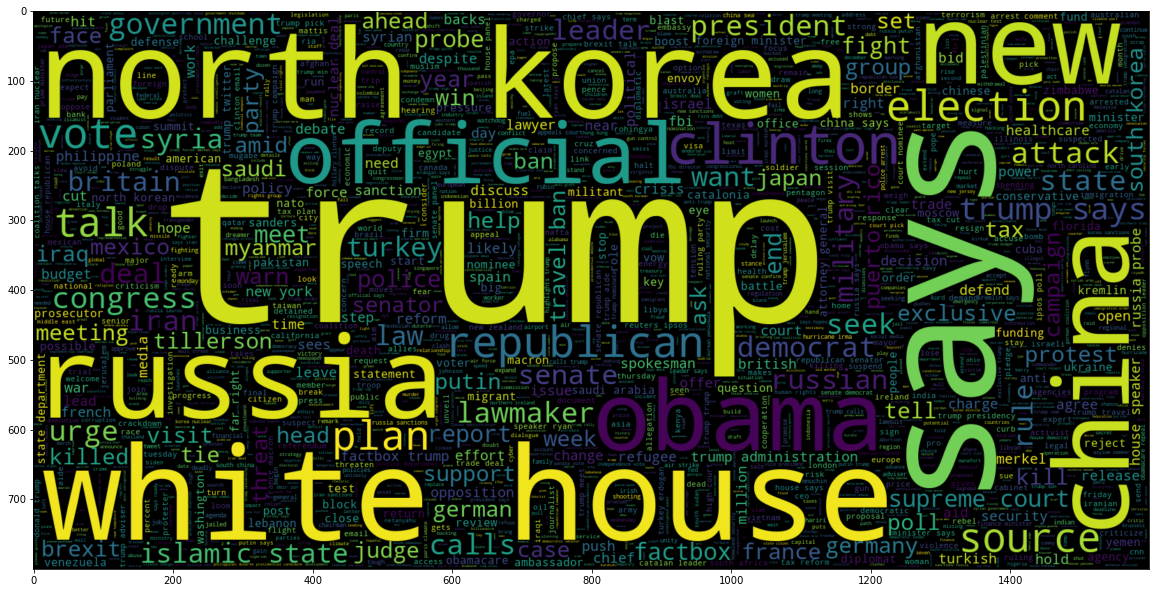

In [11]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

# Word Cloud using the Fake News Headlines


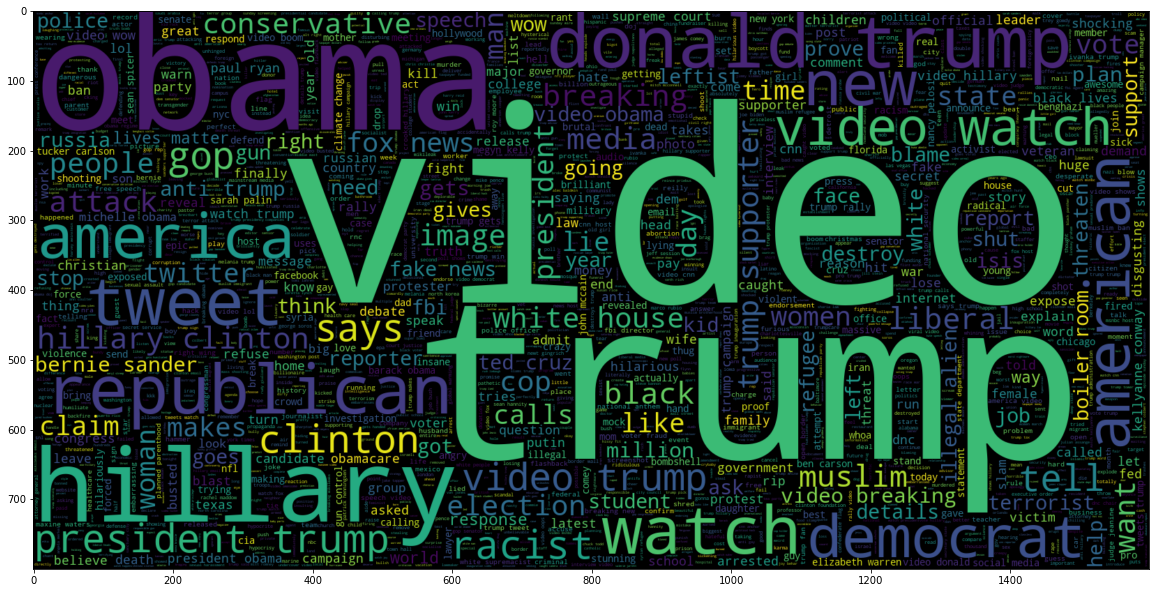

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

# Lets Look at the Count of Words Distribution in the Title

In [13]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

The maximum number of words in a title is = 34


**Observation:** On an average, The maximum number of titles range between 7-8 words. Would be a bit tricky to judge if the news if true or fake only with these few words. So we hope we shall not be getting a great amount of accuracy using the title alone. Still lets move on to our prediction

### Feature Selection with Genetic Algorithm

In [14]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 


def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [15]:
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  PoliticsNews   
1  WASHINGTON (Reuters) - Transgender people will...  PoliticsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  PoliticsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  PoliticsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  PoliticsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                         clean_title  \
0  [budget, fight, looms, republicans, flip, fisc...   
1  [military, accept, transgender, recruits, mond...   
2   [senior, republican, senator, let, mueller, job]   
3  [fbi, russia, probe, helped, australian, diplo...   
4  [trump, wants, postal, service, charge, amazon...   

                                  clean_joined_title  
0  budget fight looms republicans flip fiscal script  
1  military accept transgender recruits monday pe...  
2          senior republican senator let mueller job  
3  fbi russia probe helped australian diplomat ti...  
4  trump wants postal service charge amazon shipm...

In [16]:
from gensim.models import Word2Vec

corpus = [text.split() for text in df['clean_joined_title']]
emb_size = 100
# Train Word2Vec model
model_w2v = Word2Vec(sentences=corpus, size=emb_size, window=5, min_count=1, workers=4, sg=0)

In [17]:
meta_text_vec = []
for text in df['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_w2v.wv:
            vec += model_w2v.wv[token]
    meta_text_vec.append(vec)
meta_text_vec = np.array(meta_text_vec)
meta_text_vec.shape

(44898, 100)

In [18]:
df_embed = pd.DataFrame(meta_text_vec,columns = ['embed_{}'.format(i) for i in range(meta_text_vec.shape[1])])
final_df = pd.concat([df_embed, df[['target']]],axis = 1)
final_df.head()

embed_0    embed_1    embed_2    embed_3    embed_4    embed_5  \
0 -21.999537 -27.776037  -9.341026  23.944185  35.710747  13.046722   
1 -33.098072 -36.014101 -24.883711   8.140564  23.917303  -0.409734   
2 -23.870107 -16.676717  -1.167617   4.847455  24.193227   3.918713   
3 -17.224500 -13.774987  -0.697521   3.059264  16.670446   2.279017   
4 -29.606060 -29.030188  -7.001439  10.154611  31.813423   4.118253   

     embed_6    embed_7    embed_8    embed_9  ...   embed_91   embed_92  \
0 -70.483204  -6.673981 -22.437710  59.139256  ... -33.256042 -94.180667   
1 -69.032452   7.568077 -20.498153  35.984652  ... -24.041836 -80.678232   
2 -34.524760 -11.744835  -2.420766  35.055424  ... -15.818119 -57.309012   
3 -26.383841  -8.303036  -2.956899  23.902554  ... -10.906587 -39.552487   
4 -58.204970  -9.042307 -10.653514  53.760647  ... -25.357201 -85.084077   

    embed_93   embed_94   embed_95  embed_96  embed_97   embed_98    embed_99  \
0  35.518970  79.380972  50.453579 -3.276858 -4.117957  39.962396  117.501207   
1  20.735173  53.546707  38.568926 -4.488069  7.034152  39.192238  115.929506   
2  26.795453  38.994062  29.934936  9.569976 -8.318643  17.608498   80.693088   
3  16.014222  25.235233  17.953906  6.070469 -4.564558  12.968709   55.809486   
4  34.223040  62.487004  44.827513  5.952741 -6.385945  31.828330  114.674924   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

[5 rows x 101 columns]

In [21]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from random import randint
import warnings
warnings.filterwarnings("ignore")
classifiers = ['Logistic','KNN','XGBOOST']

models = [
          LogisticRegression(max_iter = 1000),
          KNeighborsClassifier(),
          xgb.XGBClassifier(n_estimators=300, random_state=0)
]

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

data_bc = final_df.drop(columns = 'target')
label_bc = final_df['target']
X_train,X_test, y_train, y_test = split(data_bc,label_bc)
for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Model:- ", type(model).__name__)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print()


Model:-  LogisticRegression
Accuracy: 0.838663697104677
Precision: 0.8353601496725912
Recall: 0.8274647887323944
F1 score: 0.8313937249790523

Model:-  KNeighborsClassifier
Accuracy: 0.7503786191536749
Precision: 0.7515515903801396
Recall: 0.7181245366938473
F1 score: 0.7344579226686884

Model:-  XGBClassifier
Accuracy: 0.8389309576837416
Precision: 0.8465996908809892
Recall: 0.8120830244625649
F1 score: 0.8289822171774499



In [35]:
# feature extraction using Word2Vec
sentences = [nltk.word_tokenize(text) for text in df['clean_joined_title']]
word2vec_model = Word2Vec(sentences, size=100, min_count=1)
# create embeddings
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100
vocabulary_size = len(word2vec_model.wv.vocab)
tokenizer = Tokenizer(num_words= vocabulary_size, lower=True, char_level=False)
tokenizer.fit_on_texts(df['clean_joined_title'].values)
sequences = tokenizer.texts_to_sequences(df['clean_joined_title'].values)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

embedding_matrix = np.zeros((vocabulary_size + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv[word]


In [36]:
# model training
X_train, X_test, y_train, y_test = train_test_split(data, df['target'], test_size=0.2, random_state=42)


In [43]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [46]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Embedding(vocabulary_size+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(100))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [47]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
history = cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=64,
                               callbacks = [early_stopping],
                             validation_split = 0.2)


Epoch 1/10
449/449 [==============================] - 30s 66ms/step - loss: 0.4180 - accuracy: 0.7987 - val_loss: 0.3415 - val_accuracy: 0.8533
Epoch 2/10
449/449 [==============================] - 29s 65ms/step - loss: 0.3508 - accuracy: 0.8405 - val_loss: 0.3186 - val_accuracy: 0.8602
Epoch 3/10
449/449 [==============================] - 29s 65ms/step - loss: 0.3328 - accuracy: 0.8501 - val_loss: 0.3433 - val_accuracy: 0.8428
Epoch 4/10
449/449 [==============================] - 29s 65ms/step - loss: 0.3170 - accuracy: 0.8588 - val_loss: 0.3171 - val_accuracy: 0.8572
Epoch 5/10
449/449 [==============================] - 29s 65ms/step - loss: 0.3046 - accuracy: 0.8648 - val_loss: 0.2905 - val_accuracy: 0.8703
Epoch 6/10
449/449 [==============================] - 29s 65ms/step - loss: 0.2962 - accuracy: 0.8694 - val_loss: 0.2776 - val_accuracy: 0.8792
Epoch 7/10
449/449 [==============================] - 29s 65ms/step - loss: 0.2908 - accuracy: 0.8728 - val_loss: 0.2860 - val_accuracy:

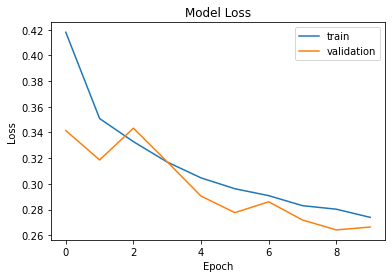

In [48]:
# Plotting train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:

# model evaluation
y_pred = cnn_lstm_model.predict_classes(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.8836302895322939
F1 Score: 0.8797053067802463
Precision: 0.8769795731007574
Recall: 0.8824480369515012


In [50]:
!pip install shap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [53]:
# import shap

# explainer = shap.Explainer(cnn_lstm_model, X_test)
# shap_values = explainer(X_test)

In [54]:
# shap.summary_plot(shap_values, X_test, plot_type='bar')

### GeFES on above models

In [55]:
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
models.append(cnn_lstm_model)

In [67]:
data_bc = final_df.drop(columns = 'target')
label_bc = final_df['target']
X_train,X_test, Y_train, Y_test = train_test_split(data_bc, label_bc,stratify= label_bc, test_size=0.2, random_state=42)
Y_train.value_counts()

0    18785
1    17133
Name: target, dtype: int64

In [ ]:
for logmodel in models:
    print("Model:- ", type(logmodel).__name__)
    chromo_df_bc,score_bc=generations(data_bc,label_bc,size=80,n_feat=data_bc.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                             X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Model:-  LogisticRegression


# Prediction- How much accurately can we predict if the News is True or Fake just from the Title?

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [15]:
model = LogisticRegression(C=2)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9475943910154114


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Observations** Damn! 94.75% accuarte prediction is quite a good result (Didn't expect it though :P). Now lets take a look at the confusion Matrix for this model using just the title

# The Confusion Matrix
![](https://images.sadhguru.org/sites/default/files/media_files/iso/en/48257-confusion-clarity-spiritual-path.jpg)

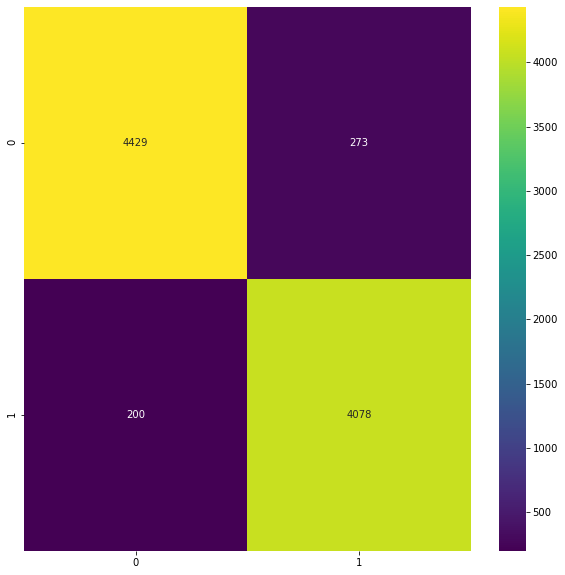

In [16]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

**Observations** 4465 Fake News have been Classified as Fake, while 4045 Real News have been classified as Real! Well Done! But we see we still have 470 titles that are misleading and are classified wrong. 

Lets think in a different approach- maybe considering the content of the News to Predict if the News if True of Fake!

# Lets Check if the Content of the News is enough to predict if the news if fake or not? Lets us see in the following analysis

In [17]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

# Lets Create the Word Clouds for the News Content Now!

# Word Cloud using the Real News Writeups


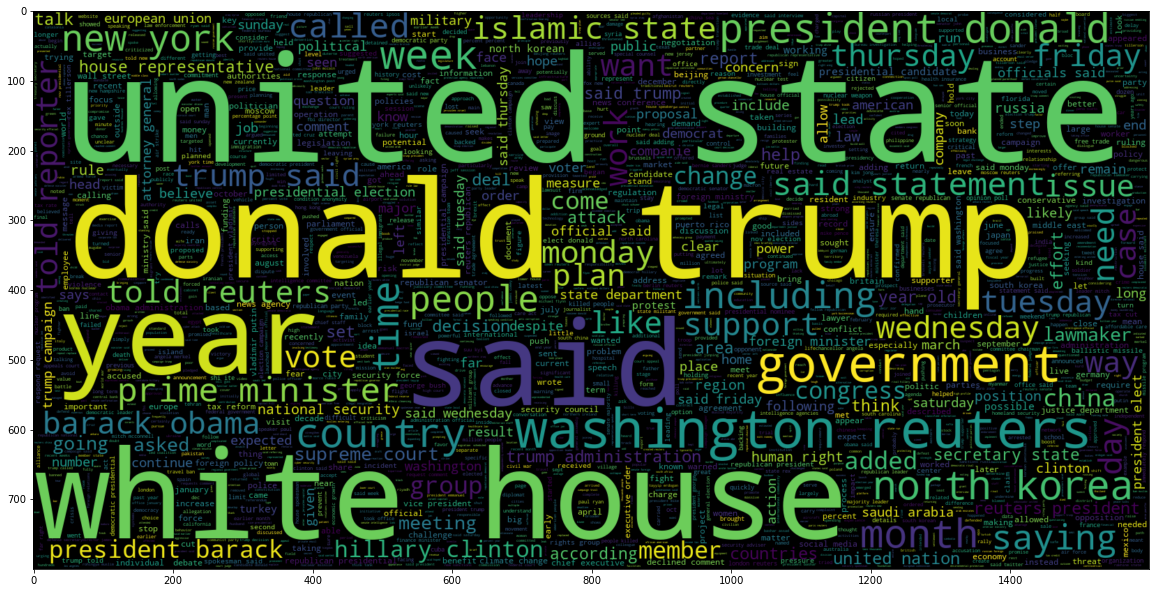

In [18]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

# Now Creating a Word Cloud using the Fake News Writeups

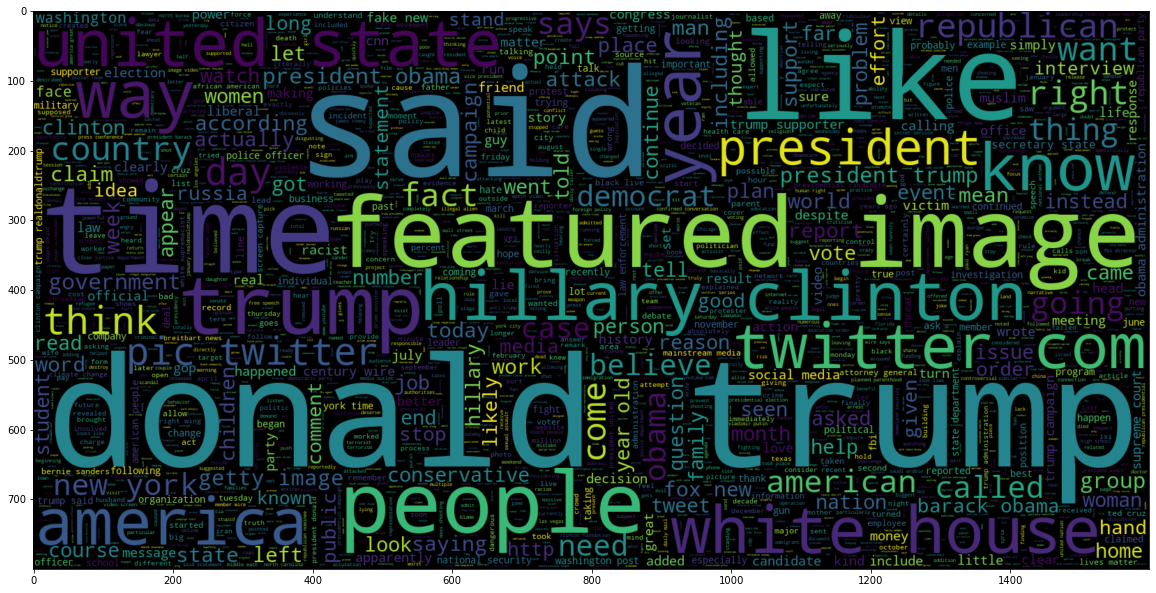

In [19]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

# Lets try to identify the distribution of word counts in the texts

In [20]:
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

The maximum number of words in a News Content is = 4573


**Observation** As we can see most of the News articles are within a range of 100-200 words. Anything beyond this point is not very catchy, and even the mdia tends to avoid. But yes when the number of words are such large, it will be much easier for the model to predict. We hope the newer accuracy is much more than the Title model. Lets check it out in our next section

# Lets Predict!!!


In [21]:

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9953661308915527


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Observation** WoooW! 99.53% That's quite an improvement. Much better than predicting from the titles. Indeed its rightly said, never judge a book by its cover, nor a news by its title. Having such a great accuracy lets for once take a look into the Confusion Matrix

# The Confusion Matrix


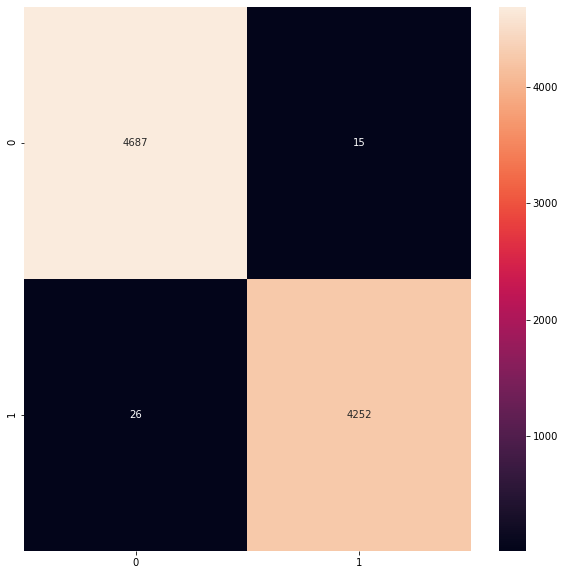

In [22]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

**Observation** This is Awesome! 4662 Contents of Fake News were classified as Fake, while 4281 Real ones were rightly predicted as well. Now we have only 41 missclassified sets. Massive improvement from our first model. But can we try to improve this any further?
What if, we combine the title and content, would it give us any better result- No harm in trying. Lets check that out in the following section

# Lets try to analyze, how accurately can we predict if we consider the entire news- Title and Content!!!

In [23]:
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=3)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9966717508706907


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Observation** 99.67%!!! Quite Perfect Score! So considering both the title and the content of the news we have been able to predict the nature of the news! For our final consolation, lets take a look at the confusion matrix!

# Confusion Matrix

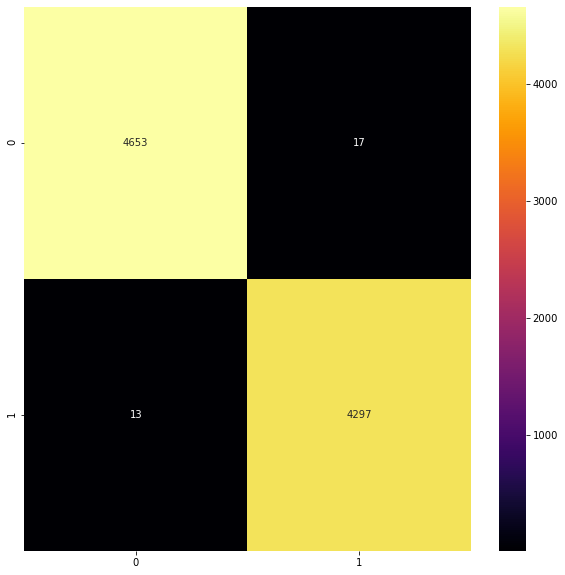

In [25]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')

**Observation** Awesome!!!! Now we are ready with our target of news Classification!

# Conclusion

![](https://www.zerys.com/hubfs/shutterstock_138382064_edited.jpg)

We have been succesfully able to reach the target for classifying a News- and are able to identify if this is a True or Fake. However would like to highligh ton a few points as mentioned below:
1. Its not much feasible to predict the news just from its title. **"Titles are misleading!!"**
2. A much better Idea was obtained when we considered the article context for the News. The accuracy percentages shot up from 94% to 99+%. Drastic Improvement it is!
3. Considering both the title and the context, we have been able to reach the highest percentages of accuracy. I shall be working on to implement further models that would give even better results.

Regarding the data, would like to add on a few points:
1. The Data obtained was clean, hence didn't require to go for much data cleaning. Have made certain modifications as per my own requirement.
2. A higher volume input would be better for the model to train- will be thinking on those lines and trying to improve this further
